Master M2A - 20/09/2021 - Lise Le Boudec

# TP 1 : Problèmes de bandits

Package à utiliser dans ce TP

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1/ Données

Lecture du fichier de données à l'aide de pandas. On note CTR les récompenses associées à chaque bras pour chaque instant t et context les éléments de contexte (non utilisés dans ce TP). 

In [3]:
data = pd.read_csv('CTR.txt', sep = ':|;', header = None, engine='python')
CTR = data.iloc[:,6:16]
context = data.iloc[:,1:5]

## 2/ Baseline

Pour commencer, 3 stratégies sont utilisées : la première consiste à tirer aléatoirement les bras. La seconde choisit toujours le même bras qui correspond au meilleur bras en moyenne. Il s'agit donc d'une stratégie non applicable en pratique puisqu'elle nécessite de connaître les récompenses avant de faire un choix. De même que la troisème, qui consiste à choisir le bras avec la meilleure récompense à chaque instant t


### Stratégie Random

Cette première stratégie consis te à sélectionner aléatoirement le bras à utiliser à chaque pas de temps. Il s'agit de la pire stratégie à adopter, puisqu'aucun apprentissage n'est tiré des coup précédents. 

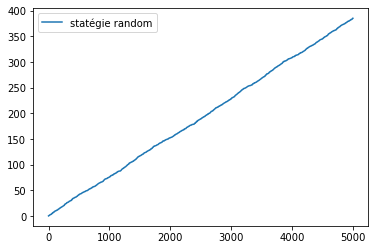

In [4]:
ind_random = np.random.randint(6, 16, 5000)
taux_random = []
for i in range(5000):
    taux_random += [CTR.at[i, ind_random[i]]]
taux_random_cumsum = np.cumsum(taux_random)

plt.plot(np.arange(5000), taux_random_cumsum)
plt.legend(['statégie random'])

### Statégie StaticBest

La seconde stratégie consiste à sélectionner le bras qui maximise la somme des taux de clics sur tous les pas de temps. Il faut donc les connaître à priori et cette stratégie n'est pas utilisable en pratique. 

9


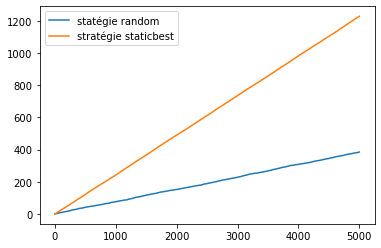

In [5]:
colomn_sum = np.sum(CTR, axis = 0)
ind_staticbest = np.argmax(colomn_sum)
print(ind_staticbest + 6)
taux_staticbest = CTR.iloc[:,ind_staticbest + 6]
taux_staticbest_cumsum = np.cumsum(taux_staticbest)
plt.plot(np.arange(5000), taux_random_cumsum, np.arange(5000), taux_staticbest_cumsum)
plt.legend(['statégie random', 'stratégie staticbest'])

Cette seconde stratégie est logiquement bien plus efficace que la première. 

### Statégie Optimale

La dernière stratégie consiste à prendre le bras qui possède la meileure récompense à chaque itération. Encore une fois, il faut avoir accès à cette information avant d'effectuer son choix, ce qui n'est pas toujours possible en pratique. 

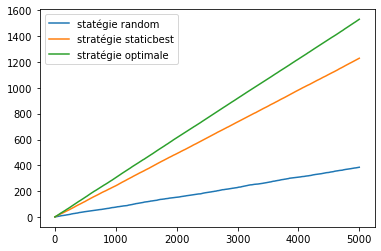

In [6]:
taux_optimal = np.max(CTR, axis = 1)
taux_optimal_cumsum = np.cumsum(taux_optimal)
plt.plot(np.arange(5000), taux_random_cumsum, np.arange(5000), taux_staticbest_cumsum, np.arange(5000), taux_optimal_cumsum)
plt.legend(['statégie random', 'stratégie staticbest', 'stratégie optimale'])

Cette troisième stratégie est encore une fois meilleure que les deux précédentes car s'agit  de la meilleure solution possible avec les données. 

## 3/ UCB

Cette section propose une implémentation de l'algorithme UCB. 

In [7]:
def ucb(data):
    """
    UCB Algorithm
    
    input:
        data (pandas dataframe) : data containing the reward for each arms for each decision
    return :
        choice (list) : list containing the number of arms chosen
        val_chosen (list) : list containing the reward obtain for the arms chosen and recorded in choice
    """ 
    

    #initialisation
    n, m = data.shape
    mu = [data.iat[i, i] for i in np.arange(0, m, 1)]
    s = np.repeat(1, m)
    t = m
    B = mu + np.sqrt(2*np.log(t)/s) 
    choice = np.arange(1, m + 1, 1)
    val_chosen = [data.iat[i, i] for i in np.arange(0, m, 1)]
    
    for i in range(10, data.shape[0], 1):
        current_choice = np.argmax(B)
        choice = np.append(choice, [current_choice])
        val_chosen = np.append(val_chosen, [data.iat[i, current_choice]])
        
        mu[current_choice] *= s[current_choice]
        mu[current_choice] += data.iat[i, choice[i]]
        s[current_choice] += 1
        mu[current_choice] /= s[current_choice]
        
        t += 1
        
        B[current_choice]  = mu[current_choice] + np.sqrt(2*np.log(t)/s[current_choice])
        
    return choice, val_chosen
        

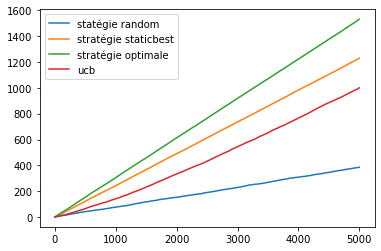

In [8]:
ind_ucb, taux_ucb = ucb(CTR)
taux_ucb_cumsum = np.cumsum(taux_ucb)
plt.plot(np.arange(5000), taux_random_cumsum, np.arange(5000), taux_staticbest_cumsum, np.arange(5000), taux_optimal_cumsum, np.arange(5000), taux_ucb_cumsum)
plt.legend(['statégie random', 'stratégie staticbest', 'stratégie optimale', 'ucb'])

L'algorithme UCB présente de bonnes performances, puisqu'il est bien plus efficace que la statégie aléatoire. En revanche, il est moins bon que la stratégie staticBest. 

## 4/ LinUCB

 Cette section propose une implémentation de l'algorithme LinUCB et basée sur le pseudo-code du cours. 

In [9]:
def linUcb(context, reward, alpha):
    """
    UCB Algorithm
    
    input:
        context (pandas dataframe) : data containing the context for each arms for each decision
        reward (pandas dataframe) : data containing the reward for each arms for each decision
        alpha (float) : parameter for the algorithm
    return :
        choice (list) : list containing the number of arms chosen
        choice_reward (list) : list containing the reward obtain for the arms chosen and recorded in choice
    """ 
    
    n, m = reward.shape #n = nb data, m = nb of arms 
    d = context.shape[1] #number of features about each arm
    
    if context.shape[0] != m:
        print('number of arms not equal to the number of features provided')
        return 0
    
    choice = []
    choice_reward = []
    
    #Initilisation des matrixes
    A = np.zeros((d, d, m)) # A matrice dxd pour chaque bras 
    b = np.zeros((d, 1, m)) # b vecteur dx1 pour chaque bras
    teta = np.zeros((d, 1, m)) # teta vecteur dx1 pour chaque bras
    p = np.zeros((1, m)) # p une valeur par bras

    for t in np.arange(0, n, 1):
        for a in np.arange(m):
            if a not in choice :
                A[:, :, a] = np.eye(d)
                b[:, :, a] = np.zeros((d, 1))
            
            teta[:, :, a] = np.dot(np.linalg.inv(A[:, :, a]), b[:, :, a])
            p[:, a] = np.dot(np.transpose(teta[:, :, a]), context.iloc[a, :]) + alpha*np.sqrt(np.dot(np.dot(np.transpose(context.iloc[a, :]), np.linalg.inv(A[:, :, a])), context.iloc[a, :]))
        
        current_choice = np.argmax(p)
        choice = np.append(choice, [current_choice])
        choice_reward = np.append(choice_reward, [reward.iat[t, current_choice]])

        A[:, :, current_choice] = A[:, :, current_choice] + np.dot(context.iloc[current_choice, :], np.transpose(context.iloc[current_choice, :]))
        b[:, :, current_choice] = b[:, :, current_choice] + np.dot(reward.iat[t, current_choice], context.iloc[current_choice, :])
    
    return choice, choice_reward

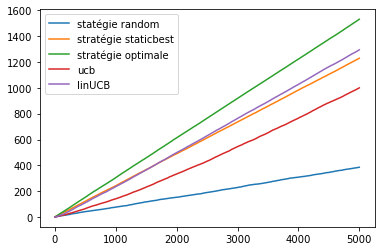

In [10]:
context = pd.DataFrame(np.transpose(np.array(np.repeat(1, 10), ndmin = 2)))
ind_linUcb, taux_linUcb = linUcb(context, CTR, 1)
taux_linUcb_cumsum = np.cumsum(taux_linUcb)
plt.plot(np.arange(5000), taux_random_cumsum, np.arange(5000), taux_staticbest_cumsum, np.arange(5000), taux_optimal_cumsum, np.arange(5000), taux_ucb_cumsum, np.arange(5000), taux_linUcb_cumsum)
plt.legend(['statégie random', 'stratégie staticbest', 'stratégie optimale', 'ucb', 'linUCB'])

LinUCB présente des performances très intéressantes. Son résultat sur le jeu de données est meilleur que les stratégies random et static best (qui utilisait le bras présentant le meilleur taux de clics moyens). 

Text(0.5, 1.0, 'taux cumulé final selon la valeur de alpha')

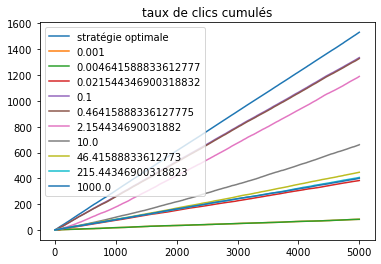

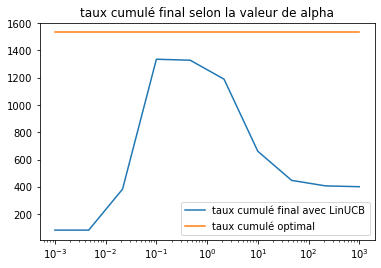

In [39]:
alphas = np.logspace(-3, 3, 10)
plt.figure()
res = []

plt.plot(np.arange(5000), taux_optimal_cumsum)
for alpha in alphas :
    ind_linUcb, taux_linUcb = linUcb(context, CTR, alpha)
    taux_linUcb_cumsum = np.cumsum(taux_linUcb)
    plt.plot(np.arange(5000), taux_linUcb_cumsum)
    res += [taux_linUcb_cumsum[-1]]
plt.plot()
plt.legend(np.concatenate((['stratégie optimale'], alphas)))
plt.title('taux de clics cumulés')

plt.figure()
plt.plot(alphas, res)
plt.plot([alphas[0], alphas[-1]], [taux_optimal_cumsum[-1:], taux_optimal_cumsum[-1:]])
plt.xscale('log')
plt.legend(['taux cumulé final avec LinUCB', 'taux cumulé optimal'])
plt.title('taux cumulé final selon la valeur de alpha')